In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

In [22]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/08_MIAR/actividades/proyecto practico"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

In [23]:
# ROOT PATH PARA LOS MODELOS Y SUS PESOS
if IN_COLAB:
  MODELS_DIR=drive_root+"/models"
else:
  MODELS_DIR="./models"

print (MODELS_DIR)

/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models


In [24]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

print (MODELS_DIR)

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Colab: making sure  /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico  exists.

Colab: Changing directory to  /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico
/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico
Archivos en el directorio: 
['.ipynb_checkpoints', 'models']
/content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models


In [25]:
# FUNCIÓN PARA PLOTEAR LOGS DEL TRAINING *** BENJAMIN ***
def analyze_training(model_name, window_size):
    """
    Analiza el log de entrenamiento de un modelo de RL, genera gráficos de evolución
    de métricas y un informe textual. Incluye un informe de métricas globales y otro
    centrado en las métricas después de los window_size ultimos episodios.
    Los graficos y datos son guardados en MODEL_DIR/graphs por fecha.

    Args:
        model_name (str): El nombre del modelo.
        window_size (int): Tamaño de la ventana para la media móvil.
    """
    MODEL_DIR = os.path.join(MODELS_DIR, model_name)
    log_csv_path = os.path.join(MODEL_DIR, f'{model_name}_training_log.csv')

    if not os.path.exists(log_csv_path):
        print(f"Error: El archivo de log '{log_csv_path}' no se encontró.")
        return

    df = pd.read_csv(log_csv_path)

    if df.empty:
        print("El DataFrame está vacío, no se puede continuar.")
        return

    # Calcular medias móviles
    df['reward_smooth'] = df['episode_reward'].rolling(window=window_size).mean()
    df['loss_smooth'] = df['loss'].rolling(window=window_size).mean()
    df['q_smooth'] = df['mean_q'].rolling(window=window_size).mean()
    df['eps_smooth'] = df['mean_eps'].rolling(window=window_size).mean()

    # Generar gráficos
    _plot_metrics(df, model_name, window_size, MODEL_DIR)

    # Informe global
    print("\nINFORME DEL TRAINING (Todas las métricas)\n" + "-" * 40)
    _print_report(df)

    # Informe últimos episodios
    _analyze_training_last(df, model_name, window_size, MODEL_DIR)

def _plot_metrics(df, model_name, window_size, model_dir):
    sns.set(style="darkgrid", font_scale=1.2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    plots_info = [
        ('episode_reward', 'reward_smooth', 'Recompensa por episodio', 'Recompensa', axes[0, 0]),
        ('loss', 'loss_smooth', 'Pérdida (loss) por episodio', 'Loss', axes[0, 1]),
        ('mean_q', 'q_smooth', 'Q medio por episodio', 'Mean Q', axes[1, 0]),
        ('mean_eps', 'eps_smooth', 'Epsilon medio por episodio', 'Mean Eps', axes[1, 1]),
    ]

    for orig_col, smooth_col, title, ylabel, ax in plots_info:
        sns.lineplot(x='episode', y=orig_col, data=df, marker='o', markersize=4, label='Original', ax=ax)
        sns.lineplot(x='episode', y=smooth_col, data=df, color='red', linewidth=2, label=f'Media móvil ({window_size})', ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Episodio')
        ax.set_ylabel(ylabel)
        ax.grid(True, linestyle='--', alpha=0.7)

        handles, labels = ax.get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        ax.legend(unique.values(), unique.keys(), loc='best')

    plt.tight_layout()
    graphs_dir = os.path.join(model_dir, "graphs")
    os.makedirs(graphs_dir, exist_ok=True)

    datetime_stamp = pd.to_datetime('today').strftime('%Y%m%d%H%M%S')
    graph_path = os.path.join(graphs_dir, f'{datetime_stamp}_{model_name}_training_analyze_graph.png')
    csv_path = os.path.join(graphs_dir, f'{datetime_stamp}_{model_name}_training_analyze_log.csv')

    plt.savefig(graph_path, dpi=300)
    df.to_csv(csv_path, index=False)
    plt.show()

    print(f"Gráfico guardado en: {graph_path}")
    print(f"CSV de informe guardado en: {csv_path}")

def _print_report(df):
    print(f"Episodios totales: {df['episode'].max()}")
    print(f"Recompensa media: {df['episode_reward'].mean():.2f}")
    print(f"Recompensa máxima: {df['episode_reward'].max()}")
    print(f"Recompensa mínima: {df['episode_reward'].min()}")
    print(f"Loss medio: {df['loss'].mean(skipna=True):.6f}")
    print(f"Mean Q medio: {df['mean_q'].mean(skipna=True):.6f}")
    print(f"Epsilon medio: {df['mean_eps'].mean(skipna=True):.6f}")
    print(f"Pasos medios por episodio: {df['nb_steps'].mean():.2f}")

    if len(df) > 1:
        reward_diff = df['episode_reward'].iloc[-1] - df['episode_reward'].iloc[0]
        if reward_diff > 0:
            print(f"La recompensa final ({df['episode_reward'].iloc[-1]:.2f}) es mayor que la inicial ({df['episode_reward'].iloc[0]:.2f}), indicando una mejora.")
        else:
            print(f"La recompensa final ({df['episode_reward'].iloc[-1]:.2f}) no ha mejorado significativamente respecto a la inicial ({df['episode_reward'].iloc[0]:.2f}).")
    else:
        print("No hay suficientes episodios para evaluar la evolución de la recompensa global.")

def _analyze_training_last(df_full, model_name, window_size, model_dir):
    latest_log_path = _get_latest_log_file(model_dir, model_name)
    if not latest_log_path:
        print("No se encontró un CSV de análisis previo para los últimos episodios.")
        return

    df = pd.read_csv(latest_log_path)
    if df.empty:
        print("El DataFrame de los últimos episodios está vacío.")
        return

    df = df.tail(window_size + 1).iloc[:-1]

    print(f"\nINFORME DEL TRAINING (últimos {window_size} episodios completados {df['episode'].min()} al {df['episode'].max()})\n" + "-" * 40)
    _print_report(df)

def _get_latest_log_file(model_dir, model_name):
    pattern = os.path.join(model_dir, "graphs", f'*_{model_name}_training_analyze_log.csv')
    files = glob.glob(pattern)
    if not files:
        return None
    return max(files, key=os.path.basename)

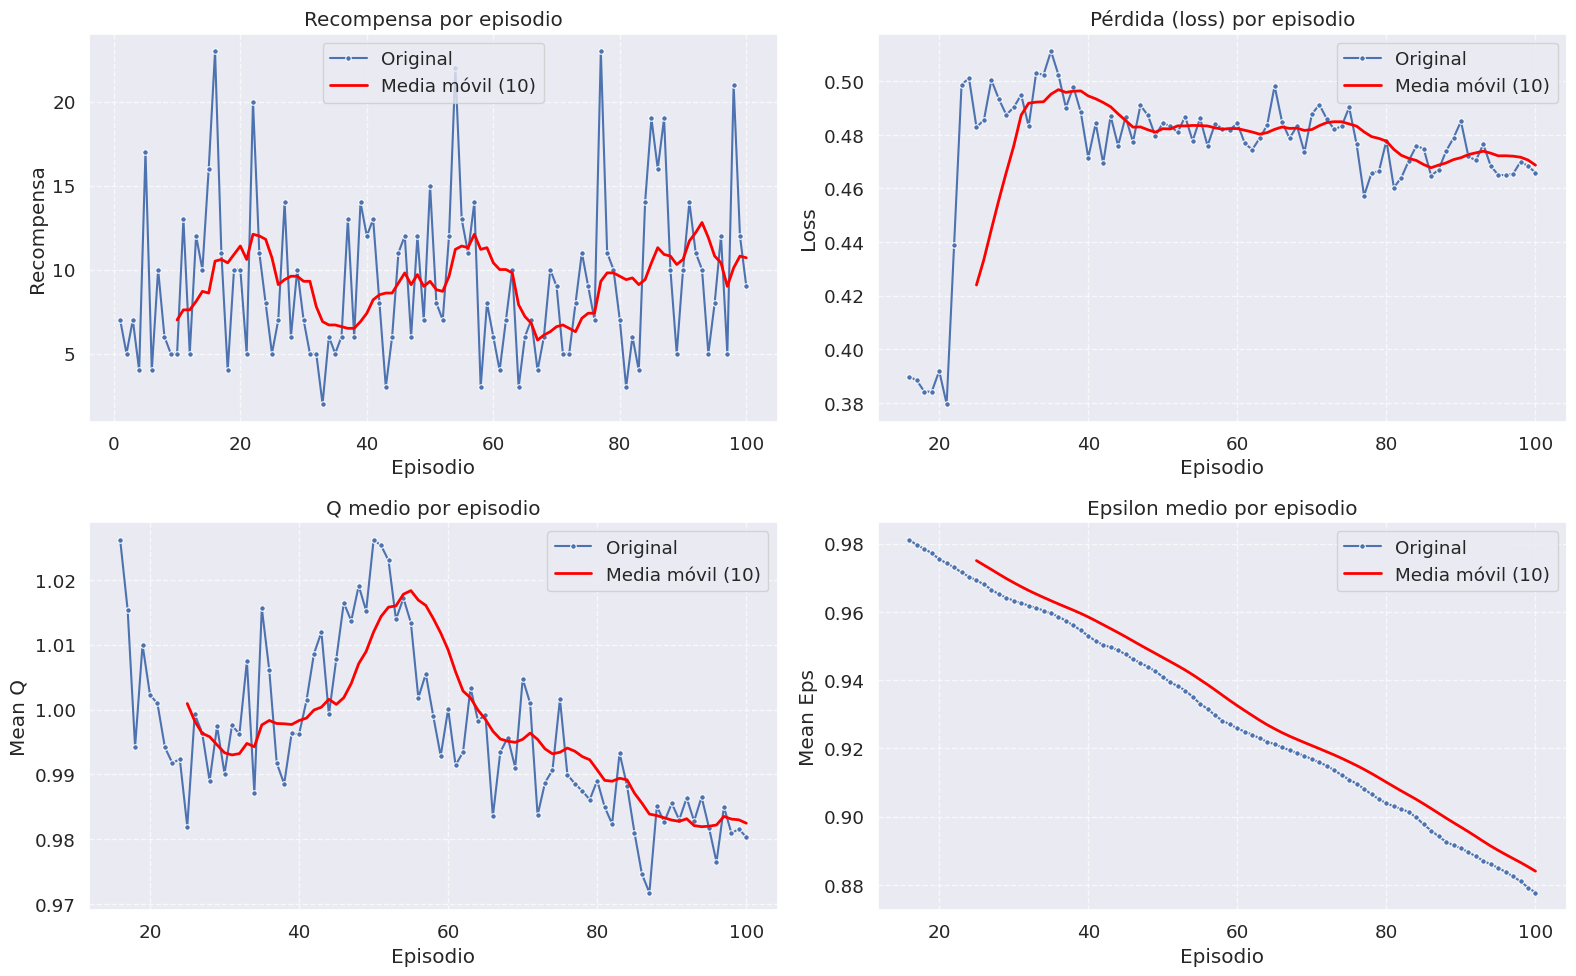

Gráfico guardado en: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/ddqn.v3.1/graphs/20250622091808_ddqn.v3.1_training_analyze_graph.png
CSV de informe guardado en: /content/gdrive/My Drive/08_MIAR/actividades/proyecto practico/models/ddqn.v3.1/graphs/20250622091808_ddqn.v3.1_training_analyze_log.csv

INFORME DEL TRAINING (Todas las métricas)
----------------------------------------
Episodios totales: 100
Recompensa media: 9.23
Recompensa máxima: 23.0
Recompensa mínima: 2.0
Loss medio: 0.473922
Mean Q medio: 0.996360
Epsilon medio: 0.930227
Pasos medios por episodio: 33974.99
La recompensa final (9.00) es mayor que la inicial (7.00), indicando una mejora.

INFORME DEL TRAINING (últimos 10 episodios completados 90 al 99)
----------------------------------------
Episodios totales: 99
Recompensa media: 10.80
Recompensa máxima: 21.0
Recompensa mínima: 5.0
Loss medio: 0.470564
Mean Q medio: 0.982981
Epsilon medio: 0.885278
Pasos medios por episodio: 64095.80
La recomp

In [29]:
model_name = "ddqn.v3.1"
# graph_model(model_name)
analyze_training(model_name,10)